# 01 – EDA (MVI – Pernambuco)

Este notebook realiza a análise descritiva do dataset processado (`data/processed/mvi_pe_features.csv`).

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/mvi_pe_features.csv", parse_dates=["date"])
display(df.head())
print("Período:", df["date"].min().date(), "→", df["date"].max().date())
print("Municípios:", df["municipio"].nunique(), "Linhas:", len(df))

,municipio,ano,mes,mvi,date,lag1,ma3,ma6,chg,alto_risco_mvi_next,mes_sin,mes_cos
0,ABREU E LIMA,2004,7,4,2004-07-01,2.0,5.000000,4.833333,-0.60,0,-0.500000,-8.660254e-01
1,ABREU E LIMA,2004,8,4,2004-08-01,4.0,3.666667,4.833333,1.00,0,-0.866025,-5.000000e-01
2,ABREU E LIMA,2004,9,1,2004-09-01,4.0,3.333333,4.833333,0.00,0,-1.000000,-1.836970e-16
3,ABREU E LIMA,2004,10,4,2004-10-01,1.0,3.000000,4.000000,-0.75,0,-0.866025,5.000000e-01
4,ABREU E LIMA,2004,11,1,2004-11-01,4.0,3.000000,3.333333,3.00,1,-0.500000,8.660254e-01


Período: 2004-07-01 → 2025-07-01
Municípios: 185 Linhas: 22076


## Série mensal total do estado + salvar figura

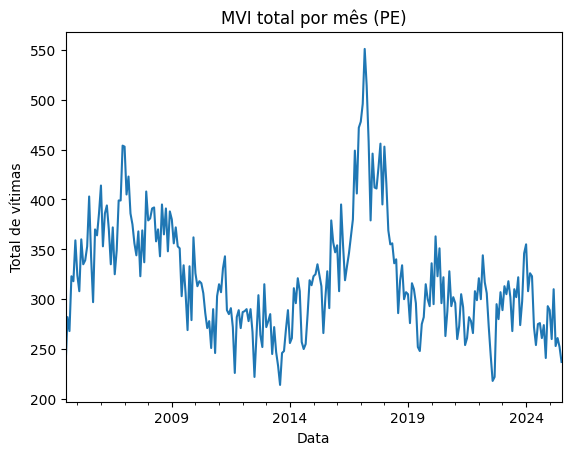

In [4]:
agg = df.groupby("date")["mvi"].sum()
ax = agg.plot(title="MVI total por mês (PE)")
ax.set_xlabel("Data"); ax.set_ylabel("Total de vítimas")
ax.figure.savefig("../reports/figuras/serie_mensal_pe.png", bbox_inches="tight")

## Top 10 municípios por MVI acumulado

municipio
RECIFE                     14739
JABOATAO DOS GUARARAPES     7936
OLINDA                      3925
CABO DE SANTO AGOSTINHO     3318
CARUARU                     3261
PAULISTA                    2715
PETROLINA                   2614
VITORIA DE SANTO ANTAO      1536
IGARASSU                    1280
CAMARAGIBE                  1229
Name: mvi, dtype: int64

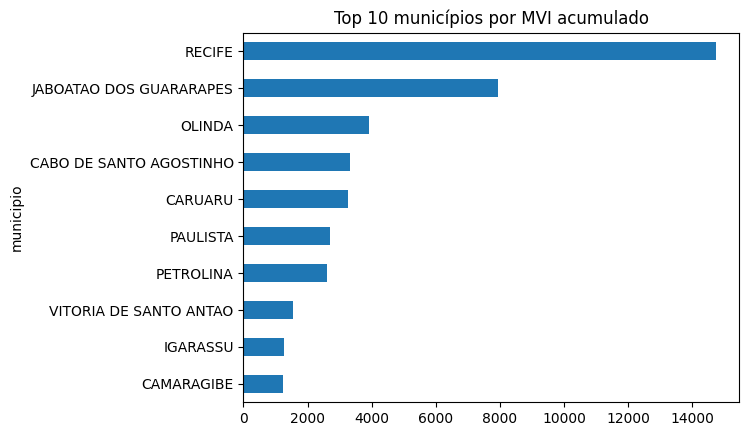

In [5]:
top = df.groupby("municipio")["mvi"].sum().sort_values(ascending=False).head(10)
display(top)
ax = top.plot(kind="barh", title="Top 10 municípios por MVI acumulado")
ax.invert_yaxis()
ax.figure.savefig("../reports/figuras/top10_municipios.png", bbox_inches="tight")

## Top 10 municípios por crescimento recente (média dos últimos 6 meses vs média histórica).

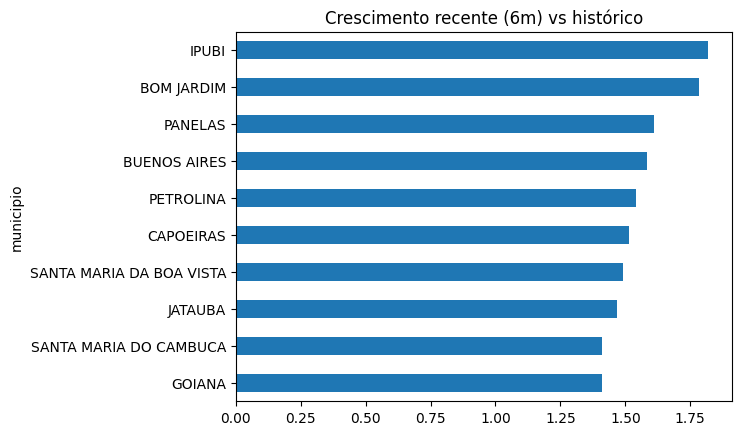

In [18]:
hist = df.groupby("municipio")["mvi"].mean()
rec = (df[df["date"] >= (df["date"].max() - pd.offsets.MonthBegin(6))]
       .groupby("municipio")["mvi"].mean())
cres = (rec / hist).dropna().sort_values(ascending=False).head(10)
ax = cres.plot(kind="barh", title="Crescimento recente (6m) vs histórico")
ax.invert_yaxis()
ax.figure.savefig("../reports/figuras/crescimento_recente.png", bbox_inches="tight")

## Série comparativa de 2–3 municípios (capital x interior) para storytelling.

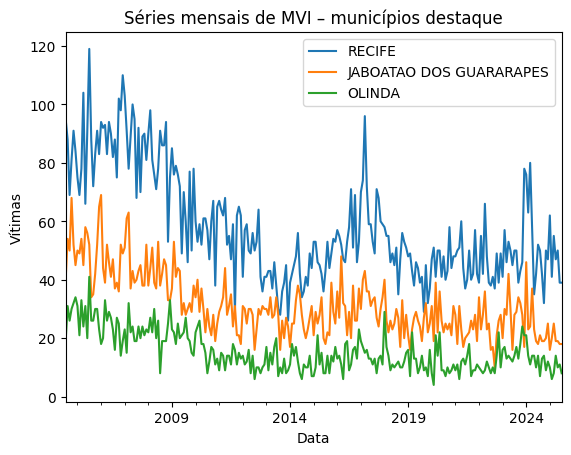

In [19]:
munis = df.groupby("municipio")["mvi"].sum().sort_values(ascending=False).head(3).index.tolist()
ax = None
for m in munis:
    sub = df[df["municipio"]==m].sort_values("date")
    ax = sub.plot(x="date", y="mvi", label=m, ax=ax)
ax.set_title("Séries mensais de MVI – municípios destaque")
ax.set_xlabel("Data"); ax.set_ylabel("Vítimas")
ax.figure.savefig("../reports/figuras/series_municipios.png", bbox_inches="tight")

## Heatmap ano x mês (MVI total no estado)

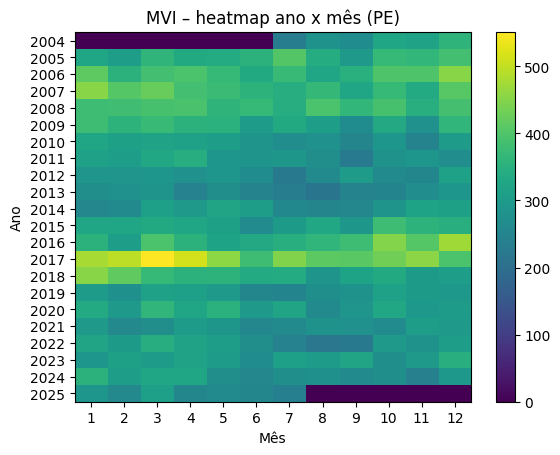

In [6]:
import matplotlib.pyplot as plt
piv = df.pivot_table(index=df["date"].dt.year, columns=df["date"].dt.month,
                     values="mvi", aggfunc="sum", fill_value=0)
plt.figure()
plt.imshow(piv.values, aspect="auto")
plt.xticks(range(12), range(1,13)); plt.yticks(range(len(piv.index)), piv.index)
plt.title("MVI – heatmap ano x mês (PE)")
plt.xlabel("Mês"); plt.ylabel("Ano"); plt.colorbar()
plt.savefig("../reports/figuras/heatmap_ano_mes.png", bbox_inches="tight"); plt.show()

## Exemplo: série de um município específico

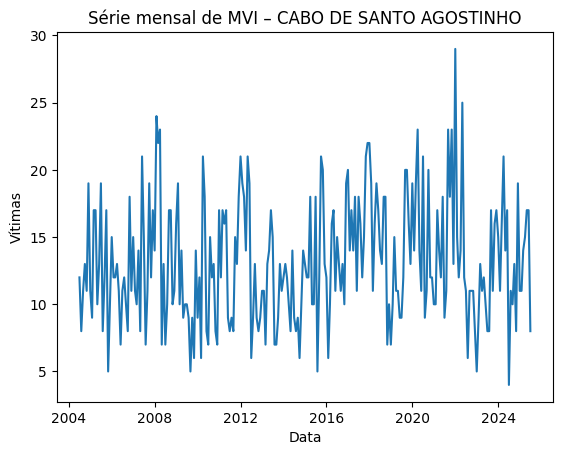

In [12]:
muni = df["municipio"].value_counts().index[0]
sub = df[df["municipio"]==muni].sort_values("date")
plt.figure()
plt.plot(sub["date"], sub["mvi"])
plt.title(f"Série mensal de MVI – {muni}")
plt.xlabel("Data"); plt.ylabel("Vítimas")
plt.show()

## Qualidade do dado (nulos, duplicados, cobertura)

In [14]:
# Qualidade
display(df.isna().mean().round(4))                     # % de nulos por coluna
print("Duplicados (município+date):", df.duplicated(["municipio","date"]).sum())

# Cobertura por município
cov = (df.groupby("municipio")
         .agg(n_meses=("date","nunique"),
              inicio=("date","min"),
              fim=("date","max"),
              total_mvi=("mvi","sum"))
         .sort_values("n_meses", ascending=False))
display(cov.head(15))
cov.to_csv("../reports/cobertura_municipios.csv", index=True)

municipio              0.0
ano                    0.0
mes                    0.0
mvi                    0.0
date                   0.0
lag1                   0.0
ma3                    0.0
ma6                    0.0
chg                    0.0
alto_risco_mvi_next    0.0
mes_sin                0.0
mes_cos                0.0
dtype: float64

Duplicados (município+date): 0


,n_meses,inicio,fim,total_mvi
municipio,,,,
CABO DE SANTO AGOSTINHO,253,2004-07-01,2025-07-01,3318
CARUARU,253,2004-07-01,2025-07-01,3261
RECIFE,253,2004-07-01,2025-07-01,14739
OLINDA,253,2004-07-01,2025-07-01,3925
JABOATAO DOS GUARARAPES,253,2004-07-01,2025-07-01,7936
PAULISTA,253,2004-07-01,2025-07-01,2715
PETROLINA,252,2004-08-01,2025-07-01,2614
VITORIA DE SANTO ANTAO,251,2004-08-01,2025-07-01,1536
IGARASSU,251,2004-07-01,2025-07-01,1280


## Série mínima para modelagem

In [ ]:
# Filtra municípios com série temporal muito curta (< 36 meses) para garantir qualidade dos dados
min_meses = 36
qtd_curta = (cov["n_meses"] < min_meses).sum()
print(f"Municípios com série < {min_meses} meses: {qtd_curta} (de {len(cov)})")

Municípios com série < 36 meses: 20 (de 185)


## Balanceamento do alvo (geral e por município)

In [ ]:
vc = df["alto_risco_mvi_next"].value_counts(normalize=True).mul(100).round(2)
print("Alvo (geral) %:", vc.to_dict())

# Por município (média do alvo = proporção de 'alto risco')
bal = df.groupby("municipio")["alto_risco_mvi_next"].mean().sort_values(ascending=False)
bal.head(10).to_csv("../reports/municipios_maior_proporcao_alto_risco.csv")
bal.tail(10).to_csv("../reports/municipios_menor_proporcao_alto_risco.csv")

Alvo (geral) %: {0: 56.0, 1: 44.0}


## Checagem anti-vazamento (futuro) nas features

In [ ]:
# Aqui só garantimos que não há NaN nas colunas usadas depois:
check_cols = ["lag1","ma3","ma6","chg","mes_sin","mes_cos"]
print("NaNs nas features:", df[check_cols].isna().sum().to_dict())

NaNs nas features: {'lag1': 0, 'ma3': 0, 'ma6': 0, 'chg': 0, 'mes_sin': 0, 'mes_cos': 0}
